In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from embedding_functions import *
from experiment_setup import *
from functions_for_bootstrap import *
import numba as nb
from scipy.stats import wasserstein_distance
from tqdm import tqdm

In [2]:
n = 500
T = 1
d = 2
B = 100  # Number of p-values to compute

# Generate an SBM
As, tau,P_t = make_iid(n, T, iid_prob=0.9)
A_obs = As[0]

In [6]:
# Bootstrap
A_boots = parametric_bootstrap(A_obs, d=d, B=B)

# Testing
p_vals = []
for i in range(B):
    A_boots_sample = A_boots[i, :, :]

    # Embed the observed and bootstrapped graphs
    Y_unf = UASE([A_obs, A_boots_sample], d=d)

    # Compute the p-value
    p_val = test_temporal_displacement_two_times(Y_unf, n)
    p_vals.append(p_val)

/home/uj21900/Documents/ResamplingAdjacencyMatrices/functions_for_bootstrap.py:59: UserWarning: P_hat contains values outside of [0,1]. Consider increasing n.
  warnings.warn("P_hat contains values outside of [0,1]. Consider increasing n.")


In [7]:
plot_power(p_vals, plot=False)

0.0

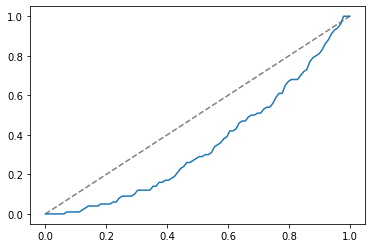

0.0

In [8]:
# Plot the cummulative p-value distribution
# If the bootstrap is good, it should be approximately uniform
# If below uniform, the bootstrap is conservative (invalid variance estimates?)
# If above uniform, the bootstrap is invalid (conservative variance estimates?)
plot_power(p_vals)

Try row sampling with replacement to get "bootstrap" matrices

In [6]:
# Bootstrap
A_row_jumble = row_sample_with_replacement(A_obs, B=B)

# Testing
p_vals = []
for i in range(B):
    A_row_jumble_sample = A_row_jumble[i, :, :]

    # Embed the observed and bootstrapped graphs
    Y_unf = UASE([A_obs, A_row_jumble_sample], d=d)

    # Compute the p-value
    p_val = test_temporal_displacement_two_times(Y_unf, n)
    p_vals.append(p_val)



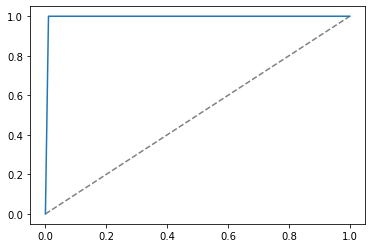

1.0

In [7]:
plot_power(p_vals)

In [8]:
plot_embedding(UASE([A_obs, A_row_jumble[0], A_row_jumble[1]], 2), n, 3, tau)

In [27]:
def edgelist_jackknife(A, B):
    """
    Pick a random entry and set it to zero
    """
    n = A.shape[0]
    A_star = np.zeros((B, n, n))

    for i in range(B):
        A_star[i] = A.copy()
        for j in range(3):
            idx = np.random.choice(n, size=2, replace=True)
            A_star[i][idx[0], idx[1]] = 0
            A_star[i][idx[1], idx[0]] = 0

    return A_star

# Bootstrap
A_jk = edgelist_jackknife(A_obs, B=B)

# Testing
p_vals = []
for i in range(B):
    A_jk_sample = A_jk[i, :, :]

    # Embed the observed and bootstrapped graphs
    Y_unf = UASE([A_obs, A_jk_sample], d=d)

    # Compute the p-value
    p_val = test_temporal_displacement_two_times(Y_unf, n)
    p_vals.append(p_val)


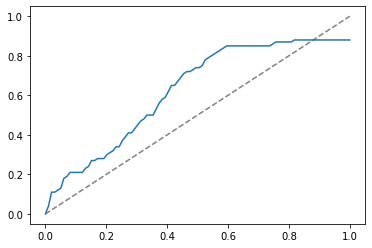

0.13

In [28]:
plot_power(p_vals)

In [40]:
plot_embedding(UASE([A_obs, A_jk[0], A_jk[1]], 2), n, 3, tau)

NameError: name 'A_jk' is not defined

## 3 April 2024 - KNN stuff

In [2]:
# Run a k-NN on a K community SBM
# Do we run k-NN on an embedding or the adjacency matrix? - should try both 
# would proof on the adj. mat be easier to prove something about?

n = 2000
T = 1
d = 2

# Generate an SBM
# As, tau = make_iid(n, T, iid_prob=0.9)

K = 5
As, tau, _ = make_temporal_simple(n, T, K=K) # K community SBM
A_obs = As[0]

In [3]:
yhat = UASE(As, d=d, flat=False)

In [39]:
# plt.plot(yhat[0, :, 0], yhat[0, :, 1], 'o', c=tau/K)
yhat_plot = UASE(As, d=d, flat=True)
plot_embedding(yhat_plot, n, T, tau)

In [6]:
# run a k-NN on the embedding yhat
# n_neighbors = n//K
n_neighbors = 5

# Here we use Minkowski distance
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree').fit(yhat[0])
distances, indices = nbrs.kneighbors(yhat[0])

# # Here we use cosine distance
# # Note we need to use brute force for cosine distance
# from sklearn.neighbors import NearestNeighbors
# nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='brute', metric='cosine').fit(yhat[0])
# distances, indices = nbrs.kneighbors(yhat[0])


# what is k?
# what is n_neighbors?
# answer: k is the number of neighbors to consider, n_neighbors is the number of neighbors to return

In [7]:
indices

array([[   0,  249,  225,  127,  115],
       [   1,  363,  376,   92,  372],
       [   2,  181,  151,  165,  149],
       ...,
       [1997, 1812, 1943, 1832, 1699],
       [1998, 1874, 1928, 1771, 1908],
       [1999, 1889, 1683, 1872, 1944]])

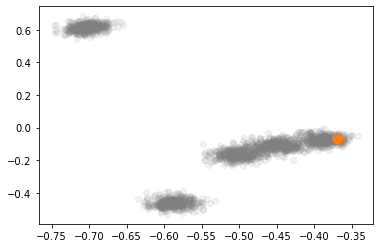

In [8]:
# plot whole embedding in the background
plt.plot(yhat[0, :, 0], yhat[0, :, 1], 'o', alpha=0.1, color='gray')
# plot the first embedding point and its neighbours
plt.plot(yhat[0, indices[0], 0], yhat[0, indices[0], 1], 'o')
plt.plot(yhat[0, 0, 0], yhat[0, 0, 1], markersize=10, marker='o')

In [9]:
import numba as nb

@nb.njit
def P_est_from_A_obs(n, A_obs):
    P_est = np.zeros((n, n))
    for i in range(n):
        idx = indices[i]
        A_i = (1/n_neighbors) * np.sum(A_obs[:, idx], axis=1)
        P_est[:, i] = A_i
    return P_est

# compile the function
P_est_fake = P_est_from_A_obs(1, np.zeros((1,1)))

In [10]:
P_est = P_est_from_A_obs(n, A_obs)

In [11]:
# P_est = np.zeros((n, n))
# for i in range(n):
#     idx = indices[i]
#     A_i = (1/n_neighbors) * np.sum(A_obs[:, idx], axis=1)
#     P_est[:, i] = A_i

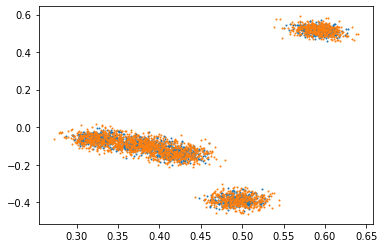

In [12]:
# # draw bernoulli trials from P_est
# A_est = np.zeros((n, n))
# for i in range(n):
#     for j in range(n):
#         A_est[i, j] = np.random.binomial(1, P_est[i, j])

A_est = make_inhomogeneous_rg(P_est)

yhat_est = UASE([A_obs,A_est], d=d, flat=False)

plt.plot(yhat_est[0, :, 0], yhat_est[0, :, 1], 'o', markersize=1)
plt.plot(yhat_est[1, :, 0], yhat_est[1, :, 1], 'o', markersize=1)

In [13]:
# TODO: we assume that KNN is deteministic???
B = 100
p_vals = []
for i in range(B):
    A_est = make_inhomogeneous_rg(P_est)

    yhat_est = UASE([A_obs,A_est], d=2)
    p_val = test_temporal_displacement_two_times(yhat_est, n)
    p_vals.append(p_val)

# yhat_est = UASE([A_obs,A_est], d=d, flat=False)

# plt.plot(yhat_est[0, :, 0], yhat_est[0, :, 1], 'o')
# plt.plot(yhat_est[1, :, 0], yhat_est[1, :, 1], 'o')

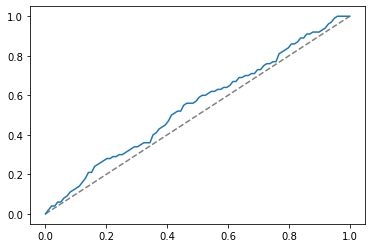

0.06

In [14]:
plot_power(p_vals)

Try k-NN on $A$ not $\hat{Y}$

In [14]:
# run a k-NN on the adjacency matrix
n_neighbors=3
nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree').fit(A_obs)
distances, indices = nbrs.kneighbors(A_obs)

In [15]:
P_est = np.zeros((n, n))
for i in range(n):
    idx = indices[i]
    A_i = (1/n_neighbors) * np.sum(A_obs[:, idx], axis=1)
    P_est[:, i] = A_i

In [16]:
# TODO: we assume that KNN is deteministic???
B = 100
p_vals = []
for i in range(B):
    A_est = make_inhomogeneous_rg(P_est)

    yhat_est = UASE([A_obs,A_est], d=2)
    p_val = test_temporal_displacement_two_times(yhat_est, n)
    p_vals.append(p_val)

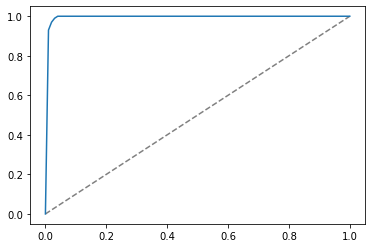

1.0

In [17]:
plot_power(p_vals)

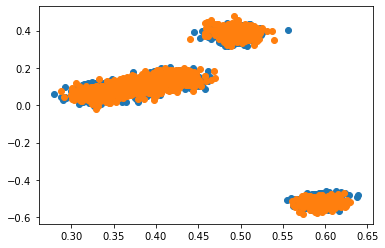

In [18]:
yhat_est = UASE([A_obs,A_est], d=d, flat=False)

plt.plot(yhat_est[0, :, 0], yhat_est[0, :, 1], 'o')
plt.plot(yhat_est[1, :, 0], yhat_est[1, :, 1], 'o')

Let's compare the kNN bootstrap with the parametric bootstrap to estimate the variance of each of $K$=2 clusters ( we will increase $K$ as we get good at coding)
We want to compare these with the truthm, and anticipate the better bootstrap will give a closer to the truth estimate of variance than the less good one

In [48]:
# Run a k-NN on a K=2 community SBM

n = 300
T = 1
d = 2

# Generate an SBM
# As, tau = make_iid(n, T, iid_prob=0.9)

K = 2
As, tau, _ = make_temporal_simple(n, T, K=K) # K community SBM
A_obs = As[0]

In [49]:
yhat = UASE(As, d=d, flat=False)

In [62]:
# run a k-NN on the embedding yhat
n_neighbors = 5

# Here we use Minkowski distance
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree').fit(yhat[0])
distances, indices = nbrs.kneighbors(yhat[0])

In [63]:
@nb.njit
def P_est_from_A_obs(n, A_obs, n_neighbors, indices):
    P_est = np.zeros((n, n))
    for i in range(n):
        idx = indices[i]
        A_i = (1/n_neighbors) * np.sum(A_obs[:, idx], axis=1)
        P_est[:, i] = A_i
    return P_est

# compile the function
# P_est_fake = P_est_from_A_obs(1, np.zeros((1,1)))

In [64]:
P_est = P_est_from_A_obs(n, A_obs, n_neighbors, indices)

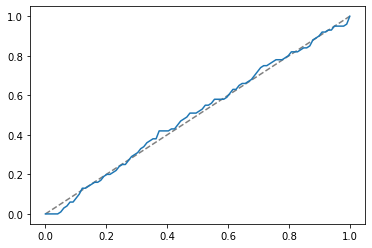

0.01

In [65]:
B = 100
p_vals = []
A_boots = []
for i in range(B):
    A_est = make_inhomogeneous_rg(P_est)

    yhat_est = UASE([A_obs,A_est], d=2)
    p_val = test_temporal_displacement_two_times(yhat_est, n)
    p_vals.append(p_val)
    A_boots.append(A_est)

#plot
plot_power(p_vals)

In [100]:
# # YUCK WE HATE THIS
# yhat_cov_ests = []

# # for each cluster, compute the covariance matrix, based on yhat obtained from A_obs
# # we assume this is the "true" cluster variance
# for clust in range(K):
#     yhat_obs_clust = yhat_obs[tau == clust]
#     cov_obs = np.cov(yhat_obs_clust, rowvar=False)
#     yhat_cov_ests.append(cov_obs)

# yhat_cov_ests_n = [yhat_cov_ests[comm] for comm in tau]
# assert len(yhat_cov_ests_n) == n

In [21]:
# Draw M samples from the same P matrix
A_redraws = []
# this means that there are the same number of bootstraps as there are draws total from P
M = B-1
for m in range(M):
    As, tau, _ = make_temporal_simple(n, T, K=K) # K community SBM
    # NEED TO MAKE SURE THE FUNCTION ABOVE DOESN'T JUMBLE THE TAUS LEAVE THEM IN ORDER FOR CHRIST'S SAKE
    A_redraws.append(As[0])

In [22]:
A_redraws_unfolded = np.column_stack(A_redraws)
assert A_redraws_unfolded.shape == (n, n*M)

In [24]:
# put A_obs and A_redraws with A_boots
A_concat = A_boots.copy()
A_concat.append(A_obs) # [A_boots, A_obs]
A_concat.extend(A_redraws) # [A_boots, A_obs, A_redraws]

yhat_concat = UASE(A_concat, d=d, flat=False)
yhat_boots = yhat_concat[:-B]
yhat_obs = yhat_concat[B:] # this is the obs and the redraws

assert len(A_concat) == 2*B

# store the n covariance matrix estimates from the bootstraps
cov_ests_boots = []
for i in range(n):
    # these are the B emebeddings of node i
    pts_node_i = yhat_boots[:, i, :]
    cov_node_i = np.cov(pts_node_i, rowvar=False) # d x d matrix
    # print(cov_node_i.shape)
    # print(cov_node_i)
    cov_ests_boots.append(cov_node_i)

# store the n covariance matrix estimates from the obs and redraws
cov_ests_obs = []
for i in range(n):
    # these are the B emebeddings of node i
    pts_node_i = yhat_obs[:, i, :]
    cov_node_i = np.cov(pts_node_i, rowvar=False) # d x d matrix
    # print(cov_node_i.shape)
    # print(cov_node_i)
    cov_ests_obs.append(cov_node_i)

need to figure out how to compare variance estimates in the d x d case

In [25]:
# compute mse between the two sets of covariance estimates for each node
mse = []
for i in range(n):
    mse_i = np.linalg.norm(cov_ests_boots[i] - cov_ests_obs[i])
    mse.append(mse_i)

In [1]:
plt.plot(mse)
print("Average MSE: ", np.mean(mse))

NameError: name 'plt' is not defined

Try looking at KL divergence

In [53]:
from scipy.stats import wasserstein_distance

cov_error = []
for i in range(n):
    boots_for_i = np.mean(yhat_boots[:, i, :], axis=1)
    obs_for_i = np.mean(yhat_obs[:, i, :], axis=1)
    wass_dist = wasserstein_distance(boots_for_i, obs_for_i)
    cov_error.append(wass_dist)

Running many bootstraps and looking at how good the variance estimation is

In [20]:
n

300

  0%|          | 0/20 [00:00<?, ?it/s]

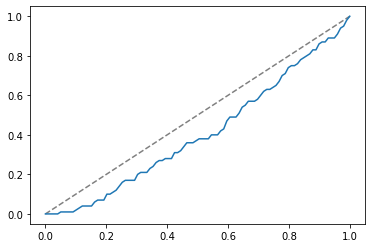

  5%|▌         | 1/20 [00:00<00:09,  1.94it/s]

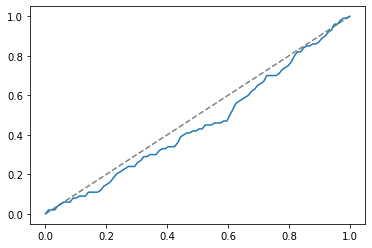

 10%|█         | 2/20 [00:01<00:09,  1.98it/s]

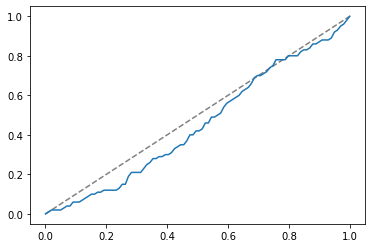

 15%|█▌        | 3/20 [00:01<00:09,  1.82it/s]

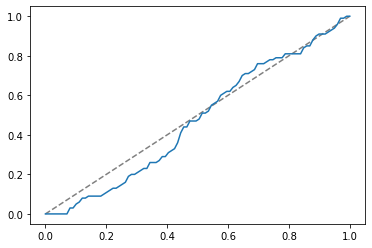

 20%|██        | 4/20 [00:02<00:08,  1.85it/s]

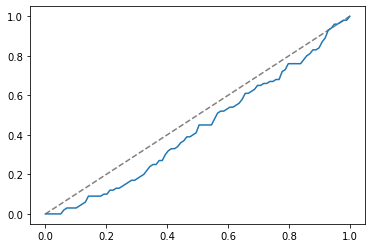

 25%|██▌       | 5/20 [00:02<00:08,  1.80it/s]

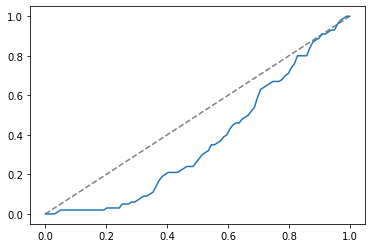

 30%|███       | 6/20 [00:03<00:07,  1.83it/s]

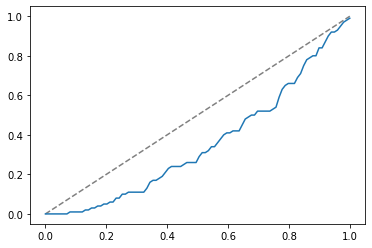

 35%|███▌      | 7/20 [00:03<00:07,  1.78it/s]

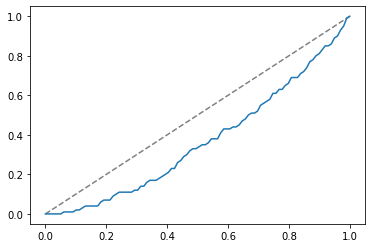

 40%|████      | 8/20 [00:04<00:06,  1.75it/s]

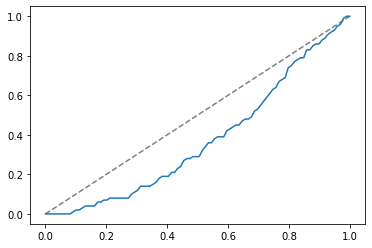

 45%|████▌     | 9/20 [00:05<00:06,  1.66it/s]

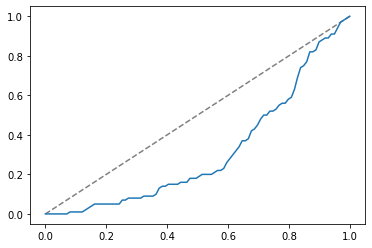

 50%|█████     | 10/20 [00:05<00:05,  1.71it/s]

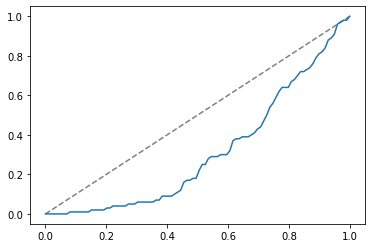

 55%|█████▌    | 11/20 [00:06<00:05,  1.76it/s]

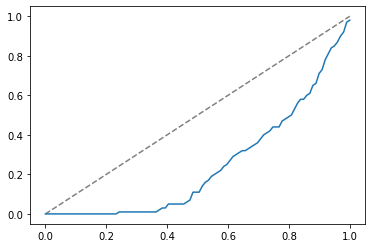

 60%|██████    | 12/20 [00:06<00:04,  1.80it/s]

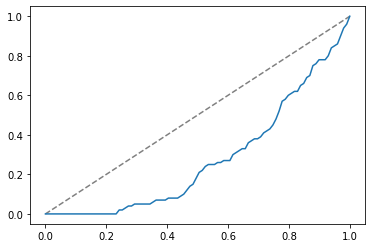

 65%|██████▌   | 13/20 [00:07<00:03,  1.77it/s]

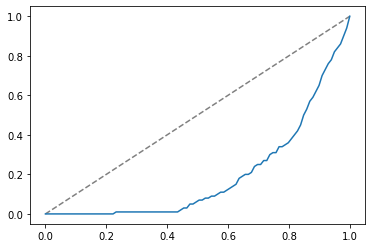

 70%|███████   | 14/20 [00:07<00:03,  1.71it/s]

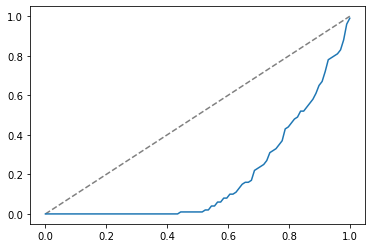

 75%|███████▌  | 15/20 [00:08<00:02,  1.78it/s]

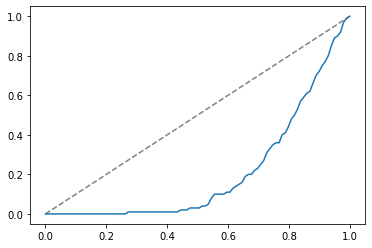

 80%|████████  | 16/20 [00:08<00:02,  1.80it/s]

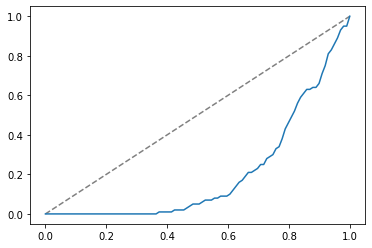

 85%|████████▌ | 17/20 [00:09<00:01,  1.81it/s]

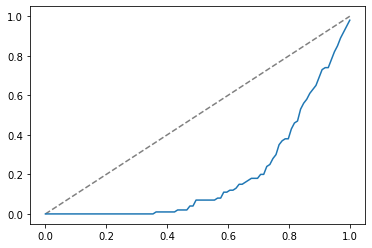

 90%|█████████ | 18/20 [00:10<00:01,  1.78it/s]

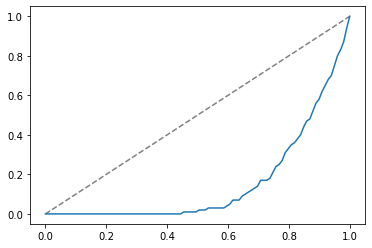

 95%|█████████▌| 19/20 [00:10<00:00,  1.66it/s]

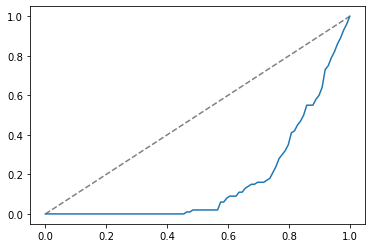

100%|██████████| 20/20 [00:11<00:00,  1.72it/s]


In [151]:
n_neighbors_to_try = [5] + list(np.linspace(n//4, n, 20).astype(int))
# n_neighbors_to_try = [5]

powers = []
avg_dist_errors = []
for n_neighbors in tqdm(n_neighbors_to_try):

    # Generate graphs -------------------------------
    n = 100
    T = 1
    d = 2
    K = 2
    As, tau, _ = make_temporal_simple(n, T, K=K) # K community SBM
    A_obs = As[0]


    # Embed the graphs -------------------------------  
    yhat = UASE(As, d=d, flat=False)

    # # run a k-NN on the embedding yhat
    # n_neighbors = 5

    # Here we use Minkowski distance
    from sklearn.neighbors import NearestNeighbors
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree').fit(yhat[0])
    distances, indices = nbrs.kneighbors(yhat[0])

    # Estimate the P matrix -------------------------------
    P_est = P_est_from_A_obs(n, A_obs, n_neighbors=n_neighbors, indices=indices)

    # Bootstrap -----------------------------------------
    B = 100
    p_vals = []
    A_boots = []
    for i in range(B):
        A_est = make_inhomogeneous_rg(P_est)

        yhat_est = UASE([A_obs,A_est], d=2)
        p_val = test_temporal_displacement_two_times(yhat_est, n)
        p_vals.append(p_val)
        A_boots.append(A_est)

    powers.append(plot_power(p_vals, plot=True))

    # Compare to true resamples -------------------------
    A_redraws = []
    M = B-1
    for m in range(M):
        As, tau, _ = make_temporal_simple(n, T, K=K) # K community SBM
        A_redraws.append(As[0])


    # Embed all together -------------------------------
    A_concat = A_boots.copy()
    A_concat.append(A_obs)
    A_concat.extend(A_redraws)

    yhat_concat = UASE(A_concat, d=d, flat=False)
    yhat_boots = yhat_concat[:B]
    yhat_obs = yhat_concat[B:]

    assert len(A_concat) == 2*B

    # Get the distance between the bootstrap and observed resamples ---------------------
    dist_errors = []
    for i in range(1):
        # Compute the distance between the bootstrapped and truly resampled embeddings
        kde_boots_i = gaussian_kde(yhat_boots[:, i, :].T)
        kde_obs_i = gaussian_kde(yhat_obs[:, i, :].T)

        dist = kl_divergence_2d(kde_boots_i, kde_obs_i)
        dist_errors.append(dist)

    avg_dist_errors.append(np.mean(dist_errors))


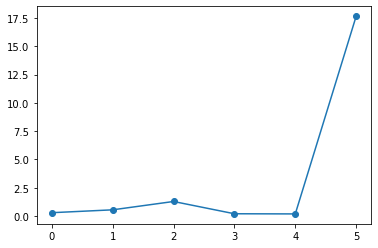

In [146]:
plt.plot(avg_dist_errors, marker="o")

In [72]:
from scipy.stats import gaussian_kde

In [ ]:
# Assuming you have your samples stored in arrays x and y
# x and y should be 1D arrays of the same length containing your sample data

# Stack x and y to create a 2D array of (x, y) pairs
xy = np.vstack([x, y])

# Fit a bivariate KDE to your data
kde = gaussian_kde(xy)

# Evaluate the KDE at a grid of points to create a density estimate
# You can specify the number of points in the grid using the 'meshgrid' function
x_grid, y_grid = np.meshgrid(np.linspace(min(x), max(x), 100),
                              np.linspace(min(y), max(y), 100))
grid_coords = np.vstack([x_grid.ravel(), y_grid.ravel()])
density_estimate = kde(grid_coords).reshape(x_grid.shape)

# 'density_estimate' now contains the estimated density values at each point of the grid

In [102]:
# node 0
yhat_boots_node0 = np.transpose(yhat_boots[:, 0, :])
yhat_obs_node0 = np.transpose(yhat_obs[:, 0, :])
yhat_obs_node0.shape

(2, 100)

In [103]:
# Fit a bivariate KDE to your data - twice
kde_boots_node0 = gaussian_kde(yhat_boots_node0)
kde_obs_node0 = gaussian_kde(yhat_obs_node0)

In [104]:
x = yhat_boots_node0[0,:]
y = yhat_boots_node0[1,:]

# Evaluate the KDE at a grid of points to create a density estimate
# You can specify the number of points in the grid using the 'meshgrid' function
x_grid, y_grid = np.meshgrid(np.linspace(min(x), max(x), 100),
                              np.linspace(min(y), max(y), 100))
grid_coords = np.vstack([x_grid.ravel(), y_grid.ravel()])
density_estimate_boots_node0 = kde_boots_node0(grid_coords).reshape(x_grid.shape)

In [105]:
x = yhat_obs_node0[0,:]
y = yhat_obs_node0[1,:]

# Evaluate the KDE at a grid of points to create a density estimate
# You can specify the number of points in the grid using the 'meshgrid' function
x_grid, y_grid = np.meshgrid(np.linspace(min(x), max(x), 100),
                              np.linspace(min(y), max(y), 100))
grid_coords = np.vstack([x_grid.ravel(), y_grid.ravel()])
density_estimate_obs_node0 = kde_obs_node0(grid_coords).reshape(x_grid.shape)

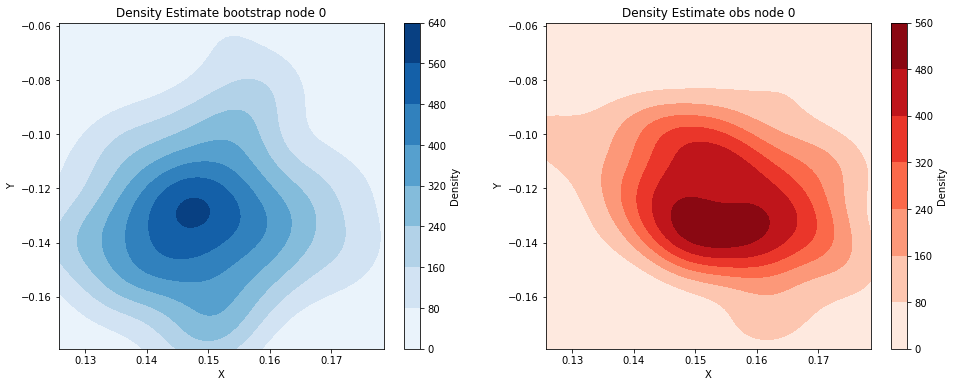

In [106]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot the first density estimate
contour1 = axes[0].contourf(x_grid, y_grid, density_estimate_boots_node0, cmap='Blues')
axes[0].set_xlabel('X')
axes[0].set_ylabel('Y')
axes[0].set_title('Density Estimate bootstrap node 0')
fig.colorbar(contour1, ax=axes[0], label='Density')

# Plot the second density estimate
contour2 = axes[1].contourf(x_grid, y_grid, density_estimate_obs_node0, cmap='Reds')
axes[1].set_xlabel('X')
axes[1].set_ylabel('Y')
axes[1].set_title('Density Estimate obs node 0')
fig.colorbar(contour2, ax=axes[1], label='Density')

plt.show()

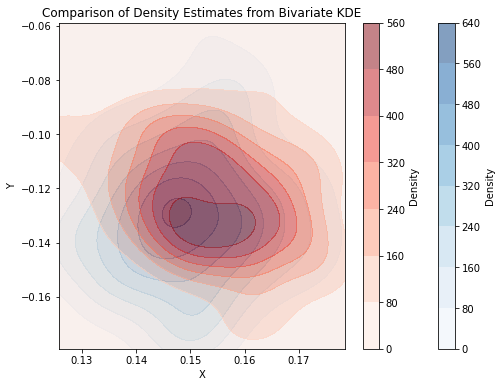

In [107]:
# Plot both density estimates
plt.figure(figsize=(8, 6))

# Plot the first density estimate
plt.contourf(x_grid, y_grid, density_estimate_boots_node0, cmap='Blues', alpha=0.5)  # alpha for transparency
plt.colorbar(label='Density')

# Plot the second density estimate
plt.contourf(x_grid, y_grid, density_estimate_obs_node0, cmap='Reds', alpha=0.5)  # alpha for transparency
plt.colorbar(label='Density')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Comparison of Density Estimates from Bivariate KDE')
plt.show()

In [108]:
from scipy.integrate import dblquad

In [142]:
# Define a function to compute the KL divergence for bivariate KDEs
def kl_divergence_2d(p, q):
    epsilon = 1e-14  # Small epsilon value to avoid division by zero
    integrand = lambda x, y: p([x, y]) * np.log((p([x, y]) + epsilon) / (q([x, y]) + epsilon))
    return dblquad(integrand, -np.inf, np.inf, -np.inf, np.inf)[0]

# Compute KL divergence
kl_div = kl_divergence_2d(kde_boots_node0.pdf, kde_obs_node0.pdf)

print("KL Divergence:", kl_div)

KL Divergence: 28.65150819730036


In [127]:
p = kde_boots_node0.pdf
q = kde_obs_node0.pdf
epsilon = 1e-14

x = yhat_boots_node0[0,:]
y = yhat_boots_node0[1,:]

integrand = lambda x, y: p([x, y]) * np.log((p([x, y]) + epsilon) / (q([x, y]) + epsilon))
integran_eval = integrand(x, y)

In [134]:

dblquad(integrand, -np.inf, np.inf, -np.inf, np.inf)

# plt.plot(integran_eval)

(28.65150819730036, 8.091934167109337e-06)

check this works

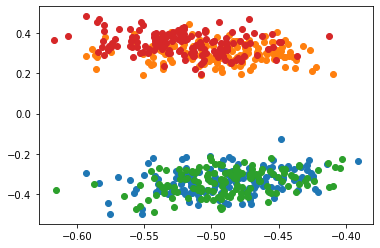

In [137]:
As, tau, _ = make_temporal_simple(n, 2, K=2) # K community SBM
ya = UASE(As, d=d, flat=False)

clust_1 = ya[0][tau == 0]
clust_2 = ya[0][tau == 1]
clust_3 = ya[1][tau == 0]
clust_4 = ya[1][tau == 1]

# plot clusters
plt.plot(clust_1[:, 0], clust_1[:, 1], 'o', c="C0")
plt.plot(clust_2[:, 0], clust_2[:, 1], 'o', c="C1")
plt.plot(clust_3[:, 0], clust_3[:, 1], 'o', c="C2")
plt.plot(clust_4[:, 0], clust_4[:, 1], 'o', c="C3")

# clust 1 and 3 are exch
# clust 2 and 4 are not


In [138]:
clust_1_kde = gaussian_kde(clust_1.T)
clust_2_kde = gaussian_kde(clust_2.T)
clust_3_kde = gaussian_kde(clust_3.T)
clust_4_kde = gaussian_kde(clust_4.T)

# Very close - should be small
integrand = lambda x, y: clust_1_kde([x, y]) * np.log((clust_1_kde([x, y]) + epsilon) / (clust_3_kde([x, y]) + epsilon))
dblquad(integrand, -np.inf, np.inf, -np.inf, np.inf)

(0.11705186152838949, 1.4847729297971022e-08)

In [139]:
# Bit further apart
integrand = lambda x, y: clust_2_kde([x, y]) * np.log((clust_2_kde([x, y]) + epsilon) / (clust_4_kde([x, y]) + epsilon))
dblquad(integrand, -np.inf, np.inf, -np.inf, np.inf)


(0.5598683824558062, 6.621876790475347e-08)

In [140]:
# Far apart
integrand = lambda x, y: clust_1_kde([x, y]) * np.log((clust_1_kde([x, y]) + epsilon) / (clust_2_kde([x, y]) + epsilon))
dblquad(integrand, -np.inf, np.inf, -np.inf, np.inf)

(35.31865210097744, 2.8181146225270722e-06)